## LDA Approximation in the 1nn case

#### Imports

In [6]:
import numpy as np
from src.utils_nambu_system import parallel_nambu_diagonalization_ising_model
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# def pade(z:np.ndarray,a_p,b_p,c_p,d_p,e_p,a_q,b_q,c_q,d_q):
#     z_poly=z[None,:]**((4-np.arange(5)))[:,None]
#     f=(z_poly[0,:]*a_p+z_poly[1,:]*b_p+z_poly[2,:]*c_p+z_poly[3,:]*d_p+z_poly[-1,:]*e_p)/(z_poly[0,:]*a_q+z_poly[1,:]*b_q+z_poly[2,:]*c_q+z_poly[3,:]*d_q)
#     return f
print((np.arange(0,9,2)))
def pade(z:np.ndarray,a_p,b_p,c_p,d_p,e_p,a_q,b_q,c_q,d_q):
    z_poly=z[None,:]**((np.arange(0,9,2)))[:,None]
    
    f=(z_poly[0,:]*a_p+z_poly[1,:]*b_p+z_poly[2,:]*c_p+z_poly[3,:]*d_p+z_poly[-1,:]*e_p)/(z_poly[0,:]*a_q+z_poly[1,:]*b_q+z_poly[2,:]*c_q+z_poly[3,:]*d_q)
    return f

def lda_functional(z:np.ndarray,coeff:np.ndarray):
    f_lda=np.zeros((z.shape[0],z.shape[-1]))
    #sorry for this free loop
    for i in range(z.shape[-1]):
        f_lda[:,i]=pade(z[:,i],a_p=coeff[0],b_p=coeff[1],c_p=coeff[2],d_p=coeff[3],e_p=coeff[4],a_q=coeff[5],b_q=coeff[6],c_q=coeff[7],d_q=coeff[8])
    return f_lda

[0 2 4 6 8]


#### Data

In [2]:
hmax=10
ndata=5000
l=16
nbatch=100
j_coupling=1
device='cpu'
pbc=True


hs=np.linspace(0,hmax,ndata)[:,None]*np.ones(l)[None,:]
_, ms, _, f, fm, e = parallel_nambu_diagonalization_ising_model(
        nbatch=nbatch,
        l=l,
        j_coupling=j_coupling,
        hs=hs,
        device=device,
        pbc=pbc,
    )

np.savez('z_lda_homogeneous_test',density=ms,f=f)

100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


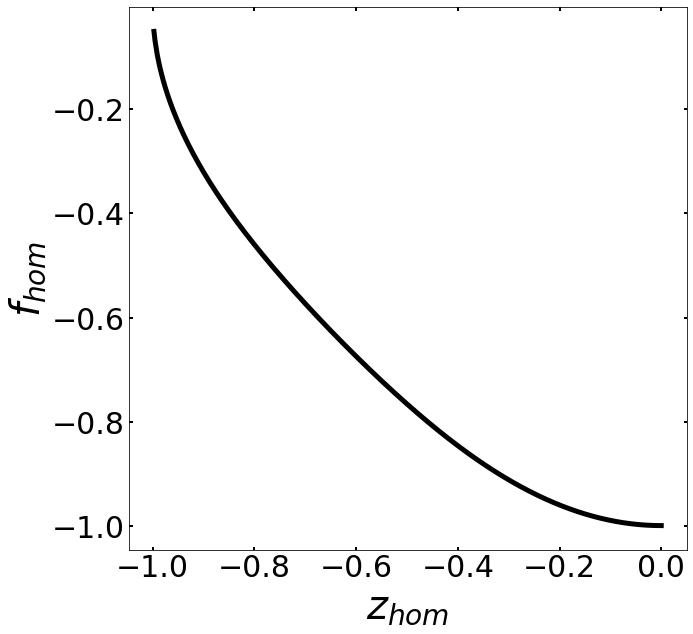

In [3]:
f=np.average(fm,axis=-1)
z=np.average(ms,axis=-1)
plt.figure(figsize=(10,10))
plt.plot(z,f,linewidth=5,color='black')
plt.ylabel(r'$f_{hom}$',fontsize=40)
plt.xlabel(r'$z_{hom}$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
plt.show()

#### Fit the LDA in case of costant fields

(9,)
(5,)
(4,)
(5000,)


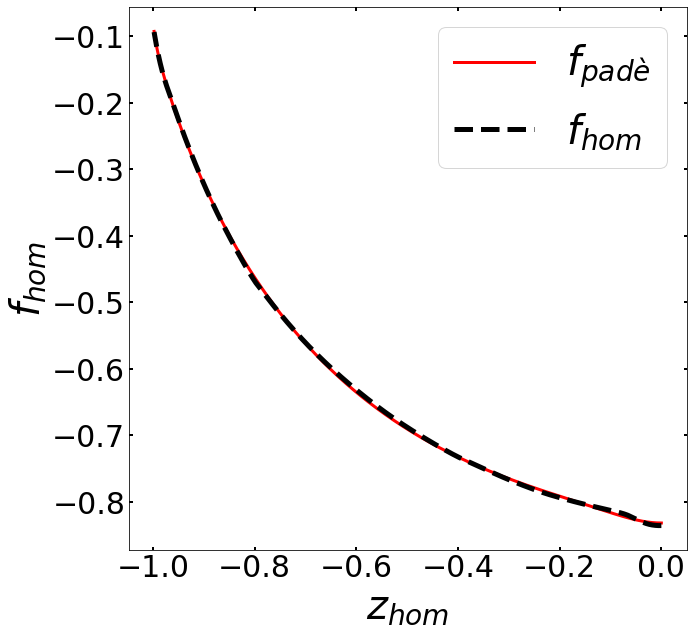

In [7]:
from model_lda import modelLDA
import torch

data=np.load('effective_lda_data.npz')
z=data['density']
f=data['f']

coeff,_=curve_fit(f=pade,xdata=z,ydata=f,)
print(coeff.shape)

coeff_p=coeff[:5]
coeff_q=coeff[5:]
print(coeff_p.shape)
print(coeff_q.shape)

model=modelLDA(torch.tensor(coeff))
f_ml=pade(z,a_p=coeff[0],b_p=coeff[1],c_p=coeff[2],d_p=coeff[3],e_p=coeff[4],a_q=coeff[5],b_q=coeff[6],c_q=coeff[7],d_q=coeff[8])

# z_poly_p=z[None,:]*(4-np.arange(5))[:,None]
# z_poly_q=z[None,:]*(3-np.arange(4))[:,None]
# f_ml=np.einsum('ka,k->a',z_poly_p,coeff_p)/np.einsum('ka,k->a',z_poly_q,coeff_q)
plt.figure(figsize=(10,10))
print(z.shape)
plt.plot(z,f_ml,color='red',label=r'$f_{padè}$',linewidth=3)
plt.plot(z,f,color='black',label=r'$f_{hom}$',linestyle='--',linewidth=5)
#plt.xlim([-0.2,0])
#plt.ylim([-1,-0.8])
plt.legend(fontsize=40)
plt.ylabel(r'$f_{hom}$',fontsize=40)
plt.xlabel(r'$z_{hom}$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
plt.show()

np.savez('f_lda',f_ml)

#### Test in the disorder Case

(200,)


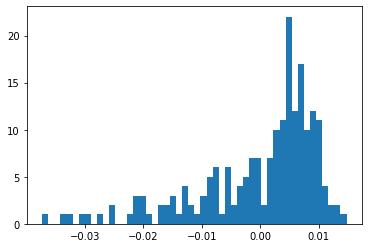

In [8]:
err=[]
dev=[]
ls=[16]
for l in ls:

    data=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_2.7_h_200_n.npz')
    z=data['density']
    f=data['density_F']
    h=data['potential']
    
    eng=f+z*h
    #f_lda=lda_functional(z,coeff=coeff)
    f_lda=model(torch.tensor(z).double()).detach().numpy()

    #err.append(np.average(np.average(np.abs(f_lda-f),axis=-1)/np.average(eng,axis=-1)))
    err.append((np.average(f_lda-f,axis=-1))/(np.average(eng,axis=-1)))
    dev.append(np.std(np.average(np.abs(f_lda-f),axis=-1)/np.average(eng,axis=-1))/np.sqrt(200))

print(err[0].shape)
plt.hist(err[0],bins=50)
plt.show()

np.save('data/lda_error',err[0])

torch.save(model,'model_lda_2')



#### Consider the LDA in the z_ave f_ave condition